# 4

4.1

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'D:\BaiduNetdiskDownload\信号试题\min_data\VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict1 = ds.bar_reader(path,props)
print(time()-start)

6.022876977920532


In [3]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1 = HFDataView()

In [4]:
dv1.create_init_dv(Time_dict1.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [5]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [6]:
alpha1 = dv1.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)

In [7]:
alpha1_plot = dv1.get_ts('alpha1_C', date_type='datetime')
close = dv1.get_ts('close', date_type='datetime')

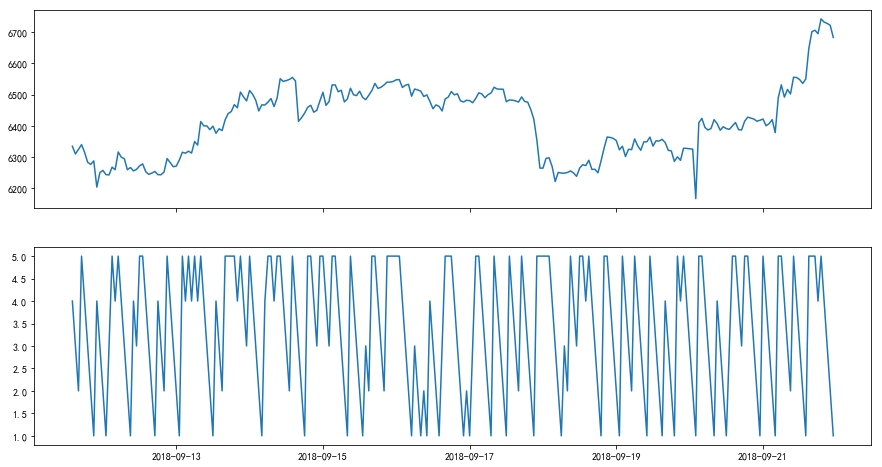

In [8]:
plot_chart(close, alpha1_plot)

画了alpha101因子中的alpha001因子

该因子描述了5日前，5日内上涨的最高收盘价或5日都下跌时的最大波动的日期坐标。根据因子算法可知，这个因子刻画了收盘价的走势，因子的转折与收盘价的转折正相关（收盘价与因子转折方向相同），且与转折的幅度无关，而在上图也得到了验证。

4.2

In [9]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

path = r'D:\BaiduNetdiskDownload\信号试题\min_data\VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000,'end_date':20181001000000}

Time_dict2 = ds.bar_reader(path,props)

In [10]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv2 = HFDataView()
dv2.create_init_dv(Time_dict2.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [11]:
data1H = Time_dict2.set_index('datetime')

In [12]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.1, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume,width=0.1)
    plt.show()

In [13]:
Morning_star = dv2.add_formula('Morning_star',"If(Ta('CDLMORNINGSTAR',0,open,high,low,close,volume)==100,100,0)",add_data=True)

In [14]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

In [15]:
MSVolume = dv2.get_ts('Morning_star', date_type='datetime')

In [16]:
MSVolumeX = MSVolume[MSVolume['BTCUSDT:binance']==100].index
MSVolumeY = data1H.loc[MSVolumeX].low-100

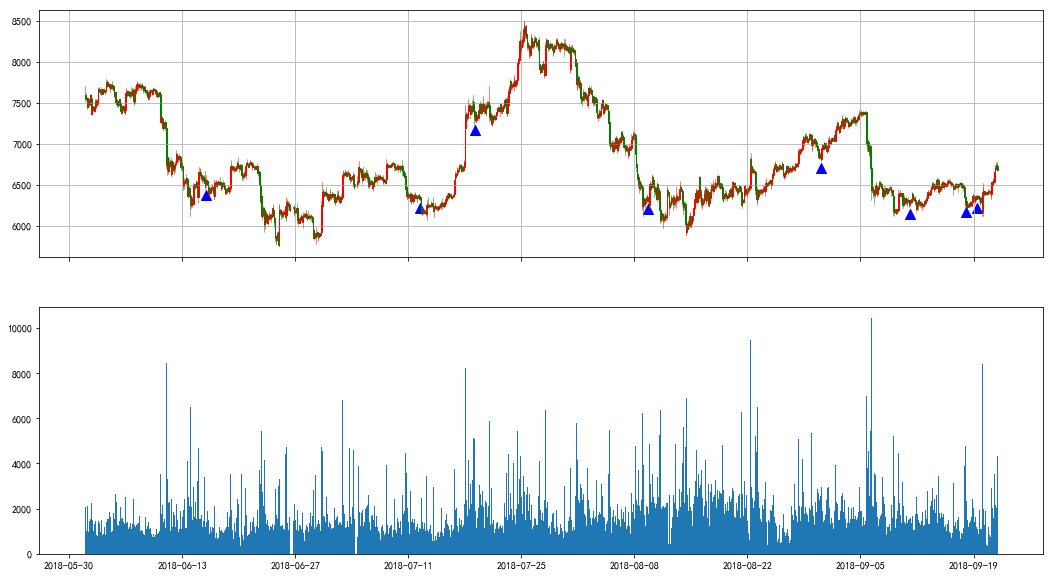

In [17]:
draw_candle(candle,MSVolumeX,MSVolumeY)

画了Morning Star因子

该因子是一个反转信号因子，由跌转升的信号。如上图，观察到该因子出现后，后续行情中会有终止下跌，并且小段上升的现象。

# 5

5.1 alpha001因子

与价格联系：因子的转折与收盘价的转折正相关（收盘价与因子转折方向相同）

信号：alpha001因子的MACD，由于close趋势上升时alpha001的均值大于下降时均值，反之下降亦然。则这里用alpha001的MACD作为close趋势的信号。

信号进出场假设：alpha001因子的MACD金叉买入，死叉卖出

5.2 Morning Star因子

与成交量联系：该因子出现后，会出现平均成交量上涨

信号：出现因子、成交量的MACD

信号进出场假设：出现因子为买入，成交量的MACD死叉卖出

# 6

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'D:\BaiduNetdiskDownload\信号试题\min_data\VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

5.924616813659668


In [4]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1H = HFDataView()

In [5]:
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [6]:
alpha1 = dv1H.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)

In [7]:
import talib as ta
import numpy as np
import pandas as pd

def calculate(alpha, timePeriod):
    mas = ta.MA(alpha.iloc[:,0].values, timePeriod)
    mal = ta.MA(alpha.iloc[:,0].values, 2*timePeriod)
    df = pd.DataFrame({'long': mal, 'short': mas}, index=alpha.index).dropna()
    df['direction'] = list(map(lambda s, l: 1 if s > l else 0, df['short'], df['long']))
    return df['direction']

In [8]:
dvAlpha = dv1H.get_ts('alpha1_C',date_type='datetime').dropna()
x = np.array(range(1,11,1))
signalDf = pd.DataFrame({t: calculate(dvAlpha, t) for t in x})

In [9]:
signalDf['signal'] = pd.Series({name: true.sum()*10 for name, true in signalDf.iterrows()})

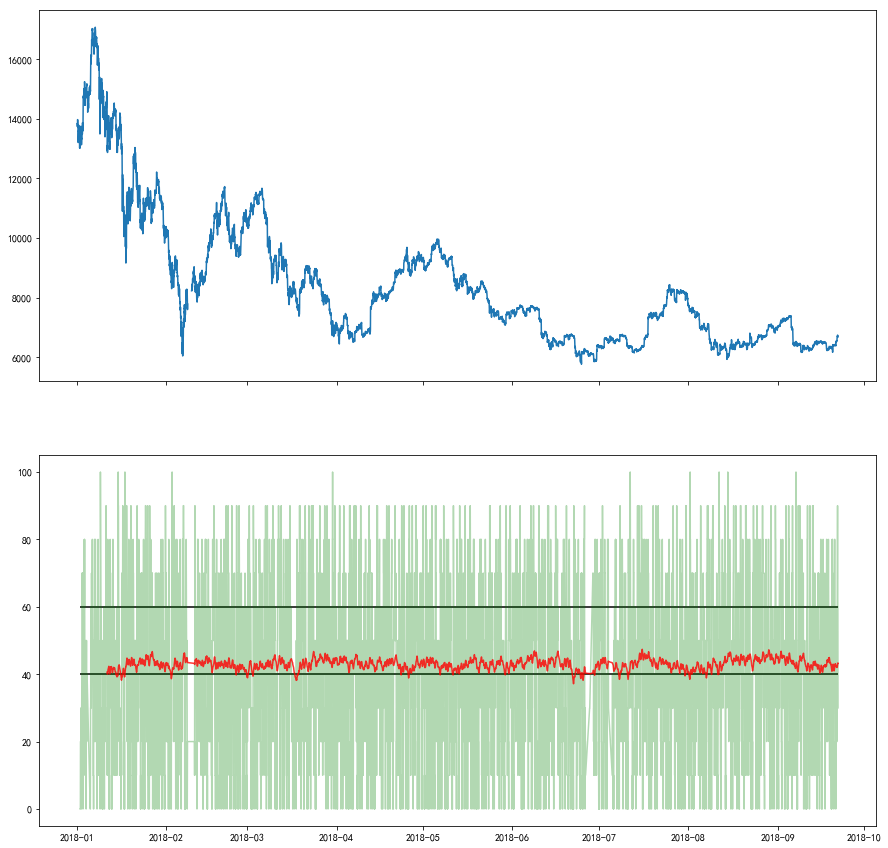

In [10]:
import matplotlib.pyplot as plt
from talib import abstract

fig, (ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv1H.get_ts('close',date_type='datetime'))
ax1.plot(signalDf['signal'], 'g', alpha=0.3)
ax1.plot(abstract.EMA(signalDf,200,price='signal'), 'r', alpha=0.8)
ax1.hlines(60, signalDf['signal'].index[0], signalDf['signal'].index[-1])
ax1.hlines(40, signalDf['signal'].index[0], signalDf['signal'].index[-1])
plt.show()

In [11]:
def signalAppend(signalDf):
    signalDf['time'] = signalDf.index
    signalDf["trade_date"] = signalDf['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    signalDf["symbol"] = "BTCUSDT:binance"
    signalDf = signalDf.set_index(["trade_date","symbol"])
    signalSe = signalDf.signal.unstack()
    dv1H.append_df(signalSe,'signalSe')
signalAppend(signalDf)

In [12]:
long = dv1H.add_formula('long','If((signalSe>=60) && (Delay(signalSe,1)<60), 2, 0)', add_data=True)
short = dv1H.add_formula('short','If((signalSe<=40) && (Delay(signalSe,1)>40), -2, 0)', add_data=True)
closeLong = dv1H.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv1H.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

In [13]:
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv1H, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 9%


In [14]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.548  -15.765   -2.480
p-value               0.000    0.000    0.013
mean                  0.016   -0.015   -0.003
std                   0.026    0.017    0.026
info_ratio            0.590   -0.877   -0.107
skewness              6.100   -2.035    2.856
kurtosis             52.327    4.836   31.588
pct5                  0.001   -0.047   -0.039
pct25                 0.003   -0.021   -0.011
pct50                 0.008   -0.008   -0.002
pct75                 0.017   -0.004    0.005
pct95                 0.051   -0.000    0.033
occurance           211.000  324.000  535.000
win_ratio               NaN      NaN    0.394
win_mean/loss_mean      NaN      NaN    1.059


In [15]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               13.544  -14.900   -0.456
p-value               0.000    0.000    0.648
mean                  0.020   -0.016   -0.001
std                   0.023    0.019    0.027
info_ratio            0.869   -0.823   -0.019
skewness              2.171   -2.877    0.276
kurtosis              7.245   11.643    5.843
pct5                  0.001   -0.052   -0.040
pct25                 0.004   -0.020   -0.012
pct50                 0.011   -0.009   -0.002
pct75                 0.029   -0.004    0.008
pct95                 0.062   -0.001    0.048
occurance           244.000  329.000  573.000
win_ratio               NaN      NaN    0.426
win_mean/loss_mean      NaN      NaN    1.271


In [16]:
tdMaStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               15.452  -21.598    -2.007
p-value               0.000    0.000     0.045
mean                  0.018   -0.015    -0.002
std                   0.025    0.018     0.027
info_ratio            0.725   -0.846    -0.060
skewness              4.342   -2.564     1.416
kurtosis             33.501    9.422    16.608
pct5                  0.001   -0.050    -0.040
pct25                 0.003   -0.021    -0.011
pct50                 0.009   -0.009    -0.002
pct75                 0.023   -0.004     0.006
pct95                 0.059   -0.000     0.042
occurance           455.000  653.000  1108.000
win_ratio               NaN      NaN     0.411
win_mean/loss_mean      NaN      NaN     1.178


# EOS

In [17]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'D:\BaiduNetdiskDownload\信号试题\min_data\VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

3.7735133171081543


In [18]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv_1H = HFDataView()

In [19]:
dv_1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [20]:
alpha1 = dv_1H.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)

In [21]:
dv_Alpha = dv_1H.get_ts('alpha1_C',date_type='datetime').dropna()
x = np.array(range(1,11,1))
signal_Df = pd.DataFrame({t: calculate(dv_Alpha, t) for t in x})

In [22]:
signal_Df['signal'] = pd.Series({name: true.sum()*10 for name, true in signal_Df.iterrows()})

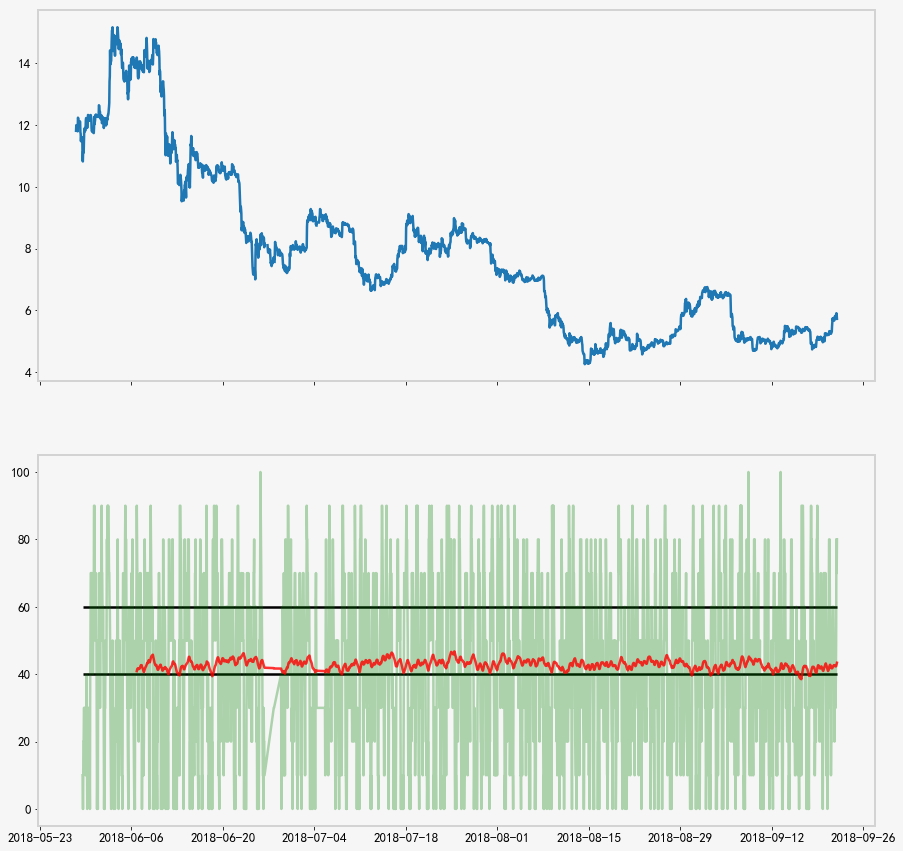

In [23]:
import matplotlib.pyplot as plt
from talib import abstract

fig, (ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv_1H.get_ts('close',date_type='datetime'))
ax1.plot(signal_Df['signal'], 'g', alpha=0.3)
ax1.plot(abstract.EMA(signal_Df,200,price='signal'), 'r', alpha=0.8)
ax1.hlines(60, signal_Df['signal'].index[0], signal_Df['signal'].index[-1])
ax1.hlines(40, signal_Df['signal'].index[0], signal_Df['signal'].index[-1])
plt.show()

In [28]:
def signalAppend(signalDf):
    signalDf['time'] = signalDf.index
    signalDf["trade_date"] = signalDf['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    signalDf["symbol"] = "EOSUSDT:binance"
    signalDf = signalDf.set_index(["trade_date","symbol"])
    signal_Se = signalDf.signal.unstack()
    dv_1H.append_df(signal_Se,'signal_Se')
signalAppend(signal_Df)

In [29]:
long = dv_1H.add_formula('long','If((signal_Se>=60) && (Delay(signal_Se,1)<60), 2, 0)', add_data=True)
short = dv_1H.add_formula('short','If((signal_Se<=40) && (Delay(signal_Se,1)>40), -2, 0)', add_data=True)
closeLong = dv_1H.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv_1H.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

In [30]:
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv_1H, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 9%


In [31]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               6.852  -11.552   -2.430
p-value              0.000    0.000    0.016
mean                 0.019   -0.020   -0.005
std                  0.026    0.021    0.030
info_ratio           0.722   -0.980   -0.160
skewness             2.716   -2.048    0.701
kurtosis             8.376    4.745    5.634
pct5                 0.001   -0.065   -0.050
pct25                0.003   -0.027   -0.016
pct50                0.009   -0.014   -0.004
pct75                0.024   -0.006    0.006
pct95                0.061   -0.002    0.042
occurance           91.000  140.000  231.000
win_ratio              NaN      NaN    0.394
win_mean/loss_mean     NaN      NaN    0.937


In [32]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat              10.427  -12.304   -0.549
p-value              0.000    0.000    0.583
mean                 0.031   -0.023   -0.001
std                  0.029    0.022    0.037
info_ratio           1.064   -1.040   -0.036
skewness             1.445   -1.347    0.509
kurtosis             1.618    1.250    1.477
pct5                 0.002   -0.073   -0.065
pct25                0.010   -0.033   -0.021
pct50                0.021   -0.017   -0.003
pct75                0.041   -0.006    0.014
pct95                0.094   -0.001    0.066
occurance           97.000  141.000  238.000
win_ratio              NaN      NaN    0.408
win_mean/loss_mean     NaN      NaN    1.316


In [33]:
tdMaStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               12.114  -16.860   -1.947
p-value               0.000    0.000    0.052
mean                  0.025   -0.022   -0.003
std                   0.028    0.022    0.034
info_ratio            0.886   -1.008   -0.090
skewness              1.903   -1.661    0.613
kurtosis              3.666    2.663    2.953
pct5                  0.001   -0.069   -0.057
pct25                 0.006   -0.029   -0.018
pct50                 0.014   -0.015   -0.004
pct75                 0.035   -0.006    0.009
pct95                 0.087   -0.002    0.055
occurance           188.000  281.000  469.000
win_ratio               NaN      NaN    0.401
win_mean/loss_mean      NaN      NaN    1.149


# 结论：策略适用于EOS